In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

from captum.attr import visualization as viz
from captum.attr import LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

plotnine.options.figure_size = (12, 12)
import warnings
warnings.filterwarnings("ignore")

In [2]:
transformer = "distilbert-base-cased"
#transformer = "roberta-base"
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(transformer)
model = AutoModelForMaskedLM.from_pretrained(transformer)
model.eval()
model.zero_grad()

In [3]:
def prepare_data_for_sentence(sent, N):
    input_seq = tokenizer.encode(sent)

    mask_index = input_seq.index(tokenizer.mask_token_id)
#    print(mask_index)

    input_tensor = torch.tensor([input_seq])

    input_result = model.forward(input_tensor, return_dict=True)

    input_result.logits.shape

    token_logits = input_result.logits
    mask_token_logits = token_logits[0, mask_index, :]
    mask_token_probs = torch.nn.functional.softmax(mask_token_logits, dim=0)

    # get the top predictions for the non-occluded sentence
    top_N = torch.topk(mask_token_probs, N, dim=0)
#    print(top_N)
    probs = top_N.values.tolist()
    top_N_tokens = top_N.indices.tolist()
#    print(probs, sum(probs), top_N_tokens)
    return input_seq, top_N_tokens, mask_index

In [4]:
def custom_forward(inputs, attention_mask=None, pos=0):
#    result = model.forward(inputs.double(), return_dict=True, attention_mask=attention_mask)
#    print("POS", pos)
    result = model.forward(inputs, return_dict=True, attention_mask=attention_mask)
    preds = result.logits
#    print("PREDS SHAPE:", preds.shape)
    N_token = preds[:, pos, :]
#()    print("SHAPE", N_token.shape)
    return N_token

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def construct_whole_bert_embeddings(input_ids, ref_input_ids):
    
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    #, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)
    #, token_type_ids=token_type_ids, position_ids=position_ids)

    return input_embeddings, ref_input_embeddings


def run_attribution_model(input_seq, ref_token_id, top_N_tokens, mask_index, layer, steps):
#    interpretable_embedding = configure_interpretable_embedding_layer(model, 'distilbert.embeddings')
    try:
        ablator = LayerIntegratedGradients(custom_forward, layer)

        input_tensor = torch.tensor([input_seq] * len(top_N_tokens))
        #ref_tensor = torch.tensor([ref_token_id]).expand((1,len(input_seq)))
        #interpretable_input_tensor = interpretable_embedding.indices_to_embeddings(input_tensor)
        #ref_tensor = interpretable_embedding.indices_to_embeddings(ref_tensor)

        attention_mask = torch.ones_like(input_tensor)
        attributions = ablator.attribute(
                inputs=input_tensor,
                baselines=int(ref_token_id),
                additional_forward_args=(attention_mask,mask_index),
                target=top_N_tokens,
                n_steps=steps,
        )
        attributions = summarize_attributions(attributions)
    finally:
        #remove_interpretable_embedding_layer(model, interpretable_embedding)
        pass
    return attributions.T

In [5]:
def build_dataframe(attributions, input_seq, top_N_tokens):

    ix = pd.CategoricalIndex(
                [tokenizer.decode([token]) for token in input_seq],
                categories=reversed([tokenizer.decode([token]) for token in input_seq]),
                ordered=True
            )
#    print(ix)
    attr_df = (
        pd.DataFrame(
                attributions.detach().numpy(), 
                columns=[tokenizer.decode([token]) for token in top_N_tokens],
                index=ix,
            )
        .reset_index()
    )
    attr_df = attr_df.melt(id_vars=["index"])
    #attr_df = attr_df[~(attr_df['index'] == tokenizer.mask_token)]
    attr_df['variable'] = pd.Categorical(
            attr_df['variable'], 
            categories = [tokenizer.decode([token]) for token in top_N_tokens], 
            ordered=True
        )
    attr_df['display_value'] = attr_df['value'].apply(lambda f: f"{f:.2f}")
    return attr_df
    

In [6]:
def create_plot(attr_df, mask_index, N):
    ncol = np.ceil(np.sqrt(N))
    return (ggplot(attr_df, aes(x="index", y="value")) + 
        geom_col(aes(fill="index", colour="index"))  +
        geom_text(aes(y="value/2", label="display_value"), size=10) +
#        geom_label(aes(x = len(input_seq) - mask_index, y= 0, label="variable"), size=13, boxstyle="darrow") +
        scale_x_discrete(drop=False) +
        facet_wrap("~variable", ncol=ncol) +
        coord_flip() +
        labs(
                x="target token",
                y="Captum contribution scores",
#                title="Exploring the contribution of each token to the prediction."
            ) +
        theme(legend_position="none")
    )

In [7]:
def run_and_show(sentence, mask_tokens, reference=[tokenizer.unk_token_id], layer=None, steps=50):
    if isinstance(mask_tokens, int):
        N = mask_tokens
        input_seq, mask_tokens, mask_index = prepare_data_for_sentence(sentence, N)
    else:
        N = len(mask_tokens)
        if isinstance(mask_tokens[0], str):
            mask_tokens = tokenizer.convert_tokens_to_ids(mask_tokens)
        input_seq, _, mask_index = prepare_data_for_sentence(sentence, N)

    attributions = []
    for ref in reference:
        attributions.append(run_attribution_model(input_seq, ref, mask_tokens, mask_index, layer, steps))
    attributions = torch.stack(attributions).mean(axis=0)
    df = build_dataframe(attributions, input_seq, mask_tokens)
    plot = create_plot(df, mask_index, N)
    display(plot)
    return df, mask_index

In [8]:
def run_no_show(sentence, mask_tokens, reference=[tokenizer.unk_token_id], layer=None, steps=50):
    if isinstance(sentence, list):
        pass
    elif isinstance(sentence, str):
        if isinstance(mask_tokens, int):
            N = mask_tokens
            input_seq, mask_tokens, mask_index = prepare_data_for_sentence(sentence, N)
        else:
            N = len(mask_tokens)
            if isinstance(mask_tokens[0], str):
                mask_tokens = tokenizer.convert_tokens_to_ids(mask_tokens)
            input_seq, _, mask_index = prepare_data_for_sentence(sentence, N)
    else:
        raise ValueError(f"Don't know what to do with input of type {type(sentence)}")

    attributions = []
    for ref in reference:
        attributions.append(run_attribution_model(input_seq, ref, mask_tokens, mask_index, layer, steps))
    attributions = torch.stack(attributions).mean(axis=0)
    df = build_dataframe(attributions, input_seq, mask_tokens)
    df['mask_index'] = mask_index
    return df, mask_index

In [9]:
from IPython.display import HTML
import re

def html_for_sentences(df, mask_index, groupings):
    if len(groupings) > 1:
        output = "<div>"
        group = groupings[0]
        for g, gdf in df.groupby(group):
            output += f"<div>{group}: {g}</div><div style='padding-left:2em;'>"
            output += html_for_sentences(gdf, mask_index, groupings[1:])
            output += "</div>"
        output += "</div>"
    else:
        output = "<table>"
        for label, lvl in df.groupby(groupings[0]):
            output += f"<tr><th>{label}</th>"
            for v, grp in lvl.groupby('variable'):
                for i, row in grp.iterrows():
                    pct = int(row['rel_value'] * 100)
                    g = 10 + pct
                    b = 150 + pct
                    if row['value'] >= 0:
                        r = g
                    else:
                        r = b
                    a = (row['rel_value'] / 2) + 0.3
                    color = ",".join(list(map(str, [r,g,b,a])))
                    size = (0.5 + (row['rel_value'] / 2) + 0.3) * 1.5

                    if i % len(grp) == row['mask_index']:
                        output += f"<td><span style='font-size: {size}em; text-decoration:underline;  color: rgba({color}'>{row['variable']}</span></td>"
                    else:
                        word = row['index'].strip()
                        word = re.sub(r'<', '&lt;', re.sub(r'>', '&gt;', word))
                        output += f"<td><span style='font-size: {size}em; color: rgba({color});'>{word}</span></td>"
            output += "</tr><tr><th/>"
            for v, grp in lvl.groupby('variable'):
                for i, row in grp.iterrows():
                    output += f"<td style='font-size: 0.7em'>{round(row['value'],3)}</td>"
            output += "</tr>"
        output += "</table>"
    return output


In [10]:
rng = np.random.default_rng()

In [11]:
%%time
sample_count = 3
full_df = None
for sample_size in [10]:#, 20, 30]:
    print("SAMPLE SIZE:", sample_size)
    size_df = None
    for step_count in [5]:#, 10, 20]:
        print("STEP COUNT:", step_count)
        step_df = None
        for k in range(sample_count):
            sample_df = None
            sample = rng.integers(model.config.vocab_size, size=sample_size)
            for sent in [
                        f"The cat from the neighbours chases a {tokenizer.mask_token}.",
#                        f"The cat from the neighbours chase a {tokenizer.mask_token}.",
#                        f"Giants are larger than {tokenizer.mask_token}.",
#                        f"four times twenty is {tokenizer.mask_token}.",
                        f"In the mirror, a man can see {tokenizer.mask_token}."
                    ]:
                sent_df = None
                for i in range(model.config.n_layers):
                    layer = getattr(model.distilbert.transformer.layer, f"{i}")
                    df, mask_index = run_no_show(sent, 1, reference=sample, layer=layer, steps=step_count)
                    df['layer'] = f"layer {i+1}"
                    df['rel_value'] = (df['value'].abs() / df['value'].abs().max()).round(2)

                    if sent_df is None:
                        sent_df = df
                    else:
                        sent_df = pd.concat([sent_df, df])
                sent_df['sent'] = sent
                if sample_df is None:
                    sample_df = sent_df
                else:
                    sample_df = pd.concat([sample_df, sent_df])
            sample_df['sample'] = k
            sample_df['sample_list'] = "; ".join([tokenizer.decode([t]) for t in sample])
            if step_df is None:
                step_df = sample_df
            else:
                step_df = pd.concat([step_df, sample_df])
        step_df['step_count'] = step_count
        if size_df is None:
            size_df = step_df
        else:
            size_df = pd.concat([size_df, step_df])
        size_df['sample_size'] = sample_size
    if full_df is None:
        full_df = size_df
    else:
        full_df = pd.concat([full_df, size_df])
        

SAMPLE SIZE: 10
STEP COUNT: 5
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
CPU times: user 3min 10s, sys: 11.3 s, total: 3min 22s
Wall time: 50.7 s


In [16]:
full_df.columns

Index(['index', 'variable', 'value', 'display_value', 'mask_index', 'layer',
       'rel_value', 'sent', 'sample', 'sample_list', 'step_count',
       'sample_size'],
      dtype='object')

In [12]:
full_df

,index,variable,value,display_value,mask_index,layer,rel_value,sent,sample,sample_list,step_count,sample_size
0,[CLS],rabbit,0.215274,0.22,9,layer 1,0.33,The cat from the neighbours chases a [MASK].,0,1897; ##↔; everywhere; Maurice; murdered; ##ı;...,5,10
1,The,rabbit,0.095085,0.10,9,layer 1,0.14,The cat from the neighbours chases a [MASK].,0,1897; ##↔; everywhere; Maurice; murdered; ##ı;...,5,10
2,cat,rabbit,0.251078,0.25,9,layer 1,0.38,The cat from the neighbours chases a [MASK].,0,1897; ##↔; everywhere; Maurice; murdered; ##ı;...,5,10
3,from,rabbit,0.032691,0.03,9,layer 1,0.05,The cat from the neighbours chases a [MASK].,0,1897; ##↔; everywhere; Maurice; murdered; ##ı;...,5,10
4,the,rabbit,0.021622,0.02,9,layer 1,0.03,The cat from the neighbours chases a [MASK].,0,1897; ##↔; everywhere; Maurice; murdered; ##ı;...,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...
7,can,clearly,0.000000,0.00,9,layer 6,0.00,"In the mirror, a man can see [MASK].",2,corporation; ##ode; faces; disguised; though; ...,5,10
8,see,clearly,0.000000,0.00,9,layer 6,0.00,"In the mirror, a man can see [MASK].",2,corporation; ##ode; faces; disguised; though; ...,5,10
9,[MASK],clearly,1.000000,1.00,9,layer 6,1.00,"In the mirror, a man can see [MASK].",2,corporation; ##ode; faces; disguised; though; ...,5,10
10,.,clearly,0.000000,0.00,9,layer 6,0.00,"In the mirror, a man can see [MASK].",2,corporation; ##ode; faces; disguised; though; ...,5,10


In [286]:
#full_df.to_parquet("20samples.parquet")

In [13]:
cosine = []
for (step_count, sample_size, sent, layer), gdf in full_df.groupby(['step_count', 'sample_size', 'sent', 'layer']):
#    print(step_count, sample_size, sent, layer)
#    display(gdf)

    for left, right in itertools.combinations(range(len(gdf['sample'].unique())), 2):
#        print(left, right)
        left_vals = np.array(gdf[gdf['sample'] == left]['value'])
        right_vals = np.array(gdf[gdf['sample'] == right]['value'])
#        print(left_vals)
#        print(right_vals)
        result = scipy.spatial.distance.cosine(
                left_vals, right_vals
            )
        cosine.append(dict(step_count=step_count, sample_size=sample_size, sent=sent, layer=layer, cosine=result))
#        print(layer, result)
cosine_df = pd.DataFrame(cosine)
cosine_df['step_count'] = pd.Categorical(cosine_df['step_count'])
cosine_df['sample_size'] = pd.Categorical(cosine_df['sample_size'])
display(cosine_df)

,step_count,sample_size,sent,layer,cosine
0,5,10,"In the mirror, a man can see [MASK].",layer 1,0.047786
1,5,10,"In the mirror, a man can see [MASK].",layer 1,0.068370
2,5,10,"In the mirror, a man can see [MASK].",layer 1,0.145662
3,5,10,"In the mirror, a man can see [MASK].",layer 2,0.027439
4,5,10,"In the mirror, a man can see [MASK].",layer 2,0.007947
5,5,10,"In the mirror, a man can see [MASK].",layer 2,0.018298
6,5,10,"In the mirror, a man can see [MASK].",layer 3,0.020753
7,5,10,"In the mirror, a man can see [MASK].",layer 3,0.033673
8,5,10,"In the mirror, a man can see [MASK].",layer 3,0.005359
9,5,10,"In the mirror, a man can see [MASK].",layer 4,0.006597


In [288]:
cosine_df.to_parquet("20samples_cosine.parquet")

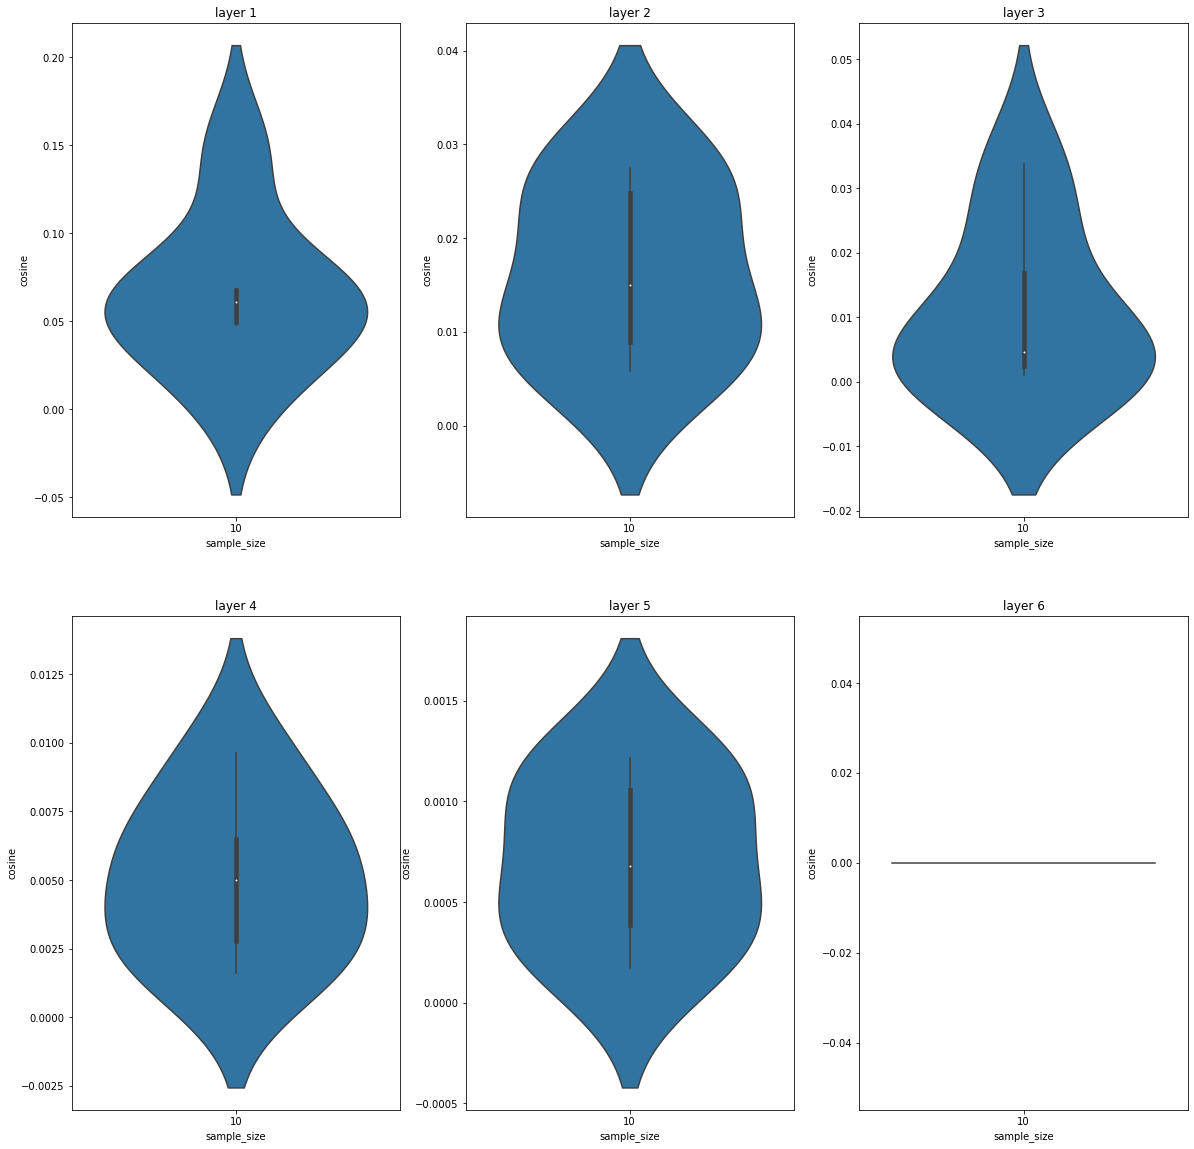

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(20, 20))
axes = axes.flatten()
for layer in range(6):
    sns.violinplot(data=cosine_df[cosine_df['layer'] == f"layer {layer + 1}"], x="sample_size", y="cosine", ax=axes[layer])
    axes[layer].set_title(f"layer {layer + 1}")

#sns.swarmplot(data=cosine_df, x="sample_size", y="cosine", hue="step_count", ax=ax)
#sns.scatterplot(data=cosine_df[cosine_df['layer'] == "layer 4"], x="sample_size", y="cosine", style="step_count", hue="sample_size", alpha=0.3, ax=ax)
#sns.swarmplot(data=cosine_df[cosine_df['layer'] == "layer 4"], x="sample_size", y="cosine", hue="step_count", ax=ax)
#sns.boxplot(data=cosine_df[cosine_df['layer'] == "layer 4"], x="sample_size", y="cosine", ax=ax)
#sns.violinplot(data=cosine_df[cosine_df['layer'] == "layer 4"], x="sample_size", y="cosine", ax=ax)

#dots = ax.collections[0]
#offsets = np.array(dots.get_offsets())
##print(offsets[10:,:], offsets.shape)
#jitter = np.random.uniform(-0.3,0.3, offsets.shape[0])
#jittered_offsets = offsets
#jittered_offsets[:,0] += jitter
##print(jittered_offsets[10:,:])
#dots.set_offsets(jittered_offsets)

#plt.tight_layout()
plt.show()

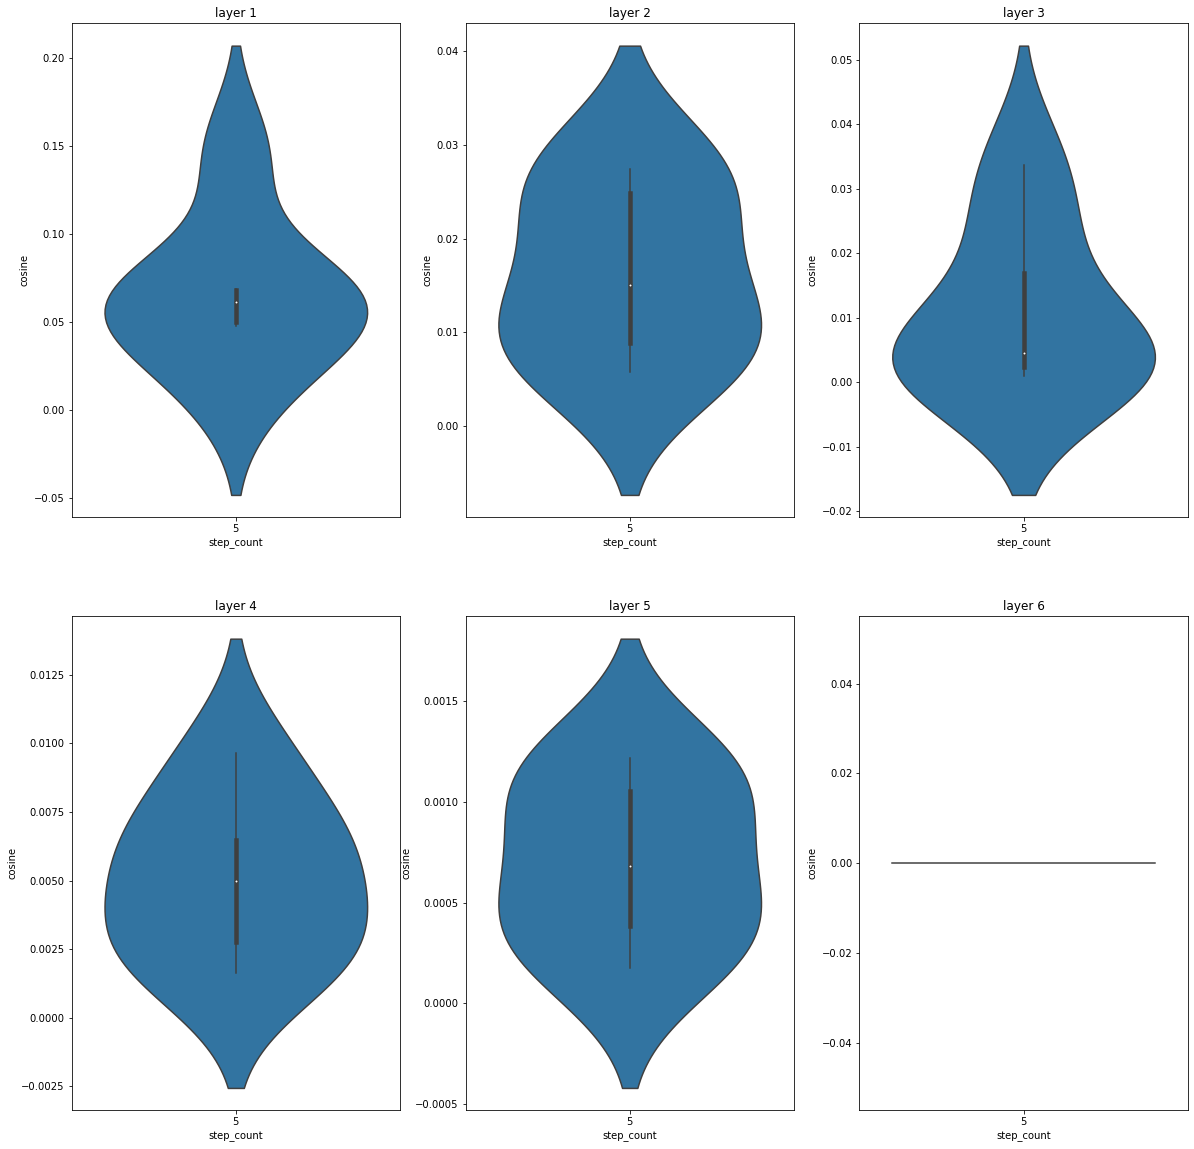

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(20, 20))
axes = axes.flatten()
for layer in range(6):
    sns.violinplot(data=cosine_df[cosine_df['layer'] == f"layer {layer + 1}"], x="step_count", y="cosine", ax=axes[layer])
    axes[layer].set_title(f"layer {layer + 1}")

#sns.swarmplot(data=cosine_df, x="sample_size", y="cosine", hue="step_count", ax=ax)
#sns.scatterplot(data=cosine_df[cosine_df['layer'] == "layer 4"], x="sample_size", y="cosine", style="step_count", hue="sample_size", alpha=0.3, ax=ax)
#sns.swarmplot(data=cosine_df[cosine_df['layer'] == "layer 4"], x="sample_size", y="cosine", hue="step_count", ax=ax)
#sns.boxplot(data=cosine_df[cosine_df['layer'] == "layer 4"], x="sample_size", y="cosine", ax=ax)
#sns.violinplot(data=cosine_df[cosine_df['layer'] == "layer 4"], x="sample_size", y="cosine", ax=ax)

#dots = ax.collections[0]
#offsets = np.array(dots.get_offsets())
##print(offsets[10:,:], offsets.shape)
#jitter = np.random.uniform(-0.3,0.3, offsets.shape[0])
#jittered_offsets = offsets
#jittered_offsets[:,0] += jitter
##print(jittered_offsets[10:,:])
#dots.set_offsets(jittered_offsets)

#plt.tight_layout()
plt.show()

In [316]:
gram = cosine_df[(cosine_df['layer'] == "layer 3") & cosine_df['sent'].isin([f"The cat from the neighbours chase a {tokenizer.mask_token}.", f"The cat from the neighbours chases a {tokenizer.mask_token}."])]

In [17]:
cosine_df.groupby(["step_count", "sample_size", "sent"]).agg({'cosine': [np.mean, np.std, np.min, np.max]})

cosine  \
                                                                         mean   
step_count sample_size sent                                                     
5          10          In the mirror, a man can see [MASK].          0.021809   
                       The cat from the neighbours chases a [MASK].  0.011333   

                                                                               \
                                                                          std   
step_count sample_size sent                                                     
5          10          In the mirror, a man can see [MASK].          0.036338   
                       The cat from the neighbours chases a [MASK].  0.019468   

                                                                          \
                                                                    amin   
step_count sample_size sent                                                
5          10          In the mirror, a man can see [MASK].          0.0   
                       The cat from the neighbours chases a [MASK].  0.0   

                                                                               
                                                                         amax  
step_count sample_size sent                                                    
5          10          In the mirror, a man can see [MASK].          0.145662  
                       The cat from the neighbours chases a [MASK].  0.066704

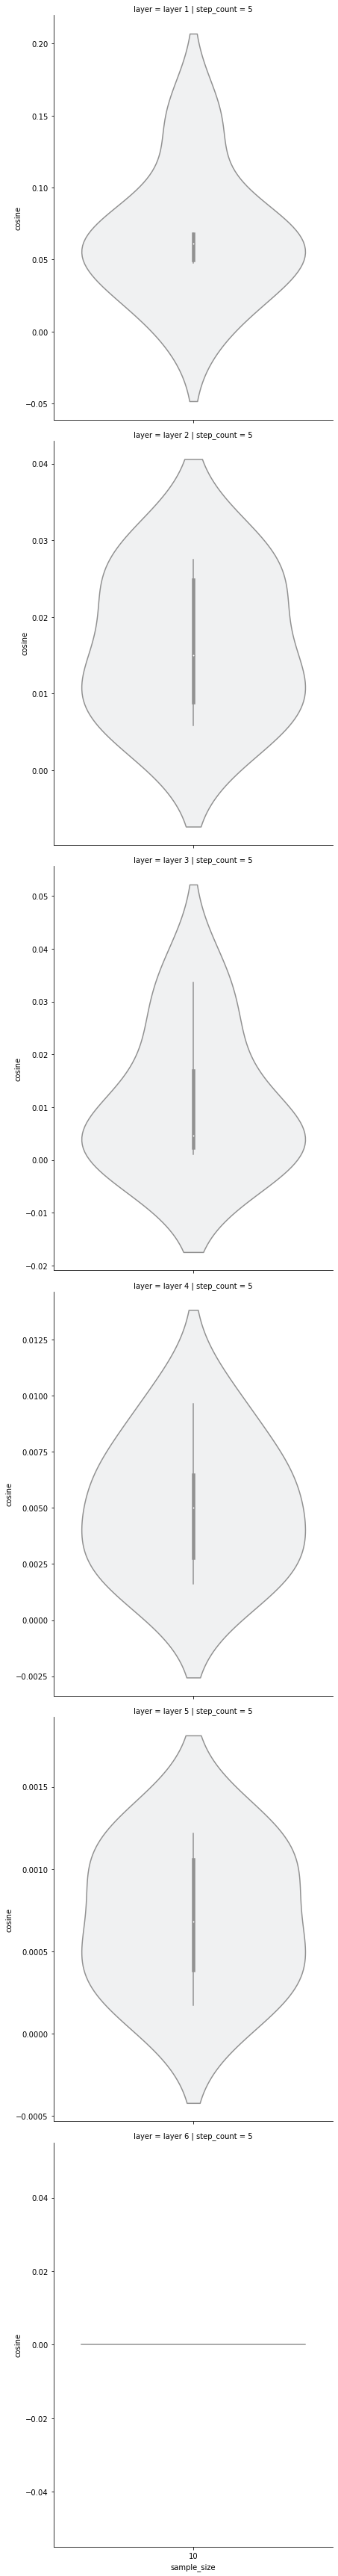

In [28]:
g = sns.FacetGrid(cosine_df, col="step_count",  row="layer", height=8, aspect=.8, sharey=False)
g.map_dataframe(sns.violinplot, y="cosine", x="sample_size", hue="sample_size")
plt.show()

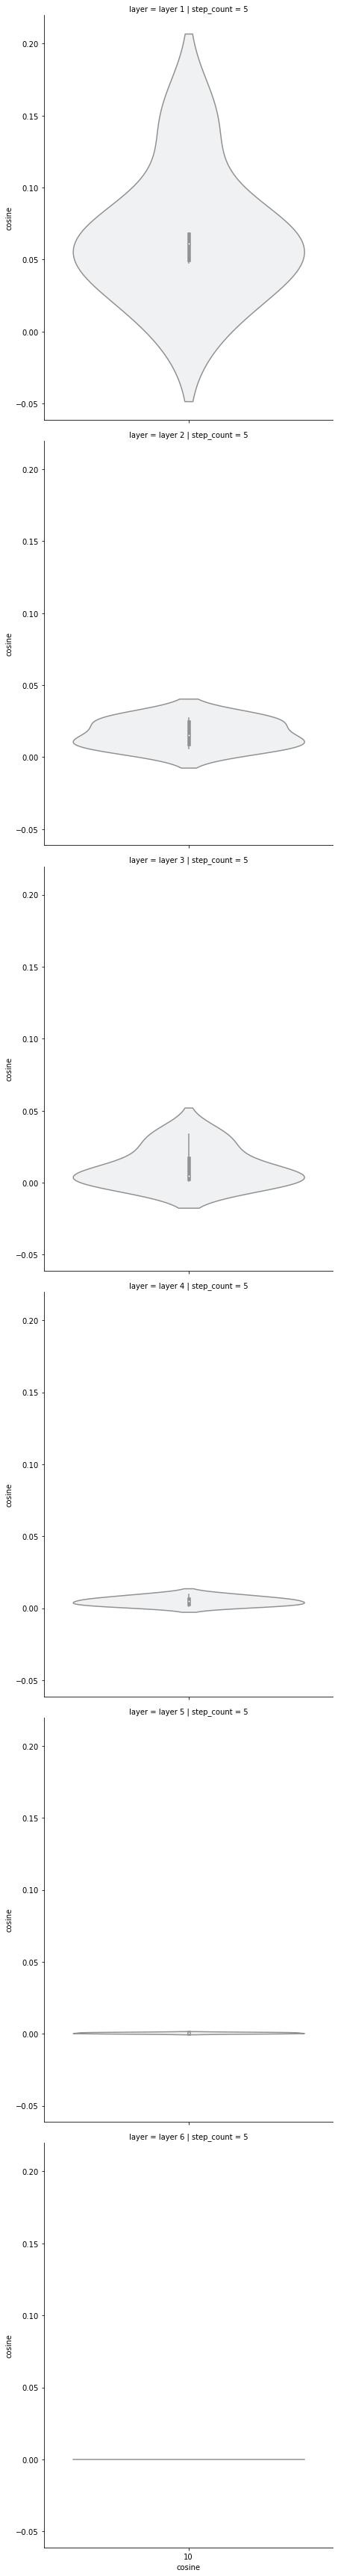

In [27]:
def make_facet(y, **kwargs):
    v = sns.violinplot(y=y,x="sample_size", hue="sample_size", **kwargs)
g = sns.FacetGrid(cosine_df, col="step_count",  row="layer", height=8, aspect=.8, sharey=True)
g.map_dataframe(make_facet, "cosine")
plt.show()

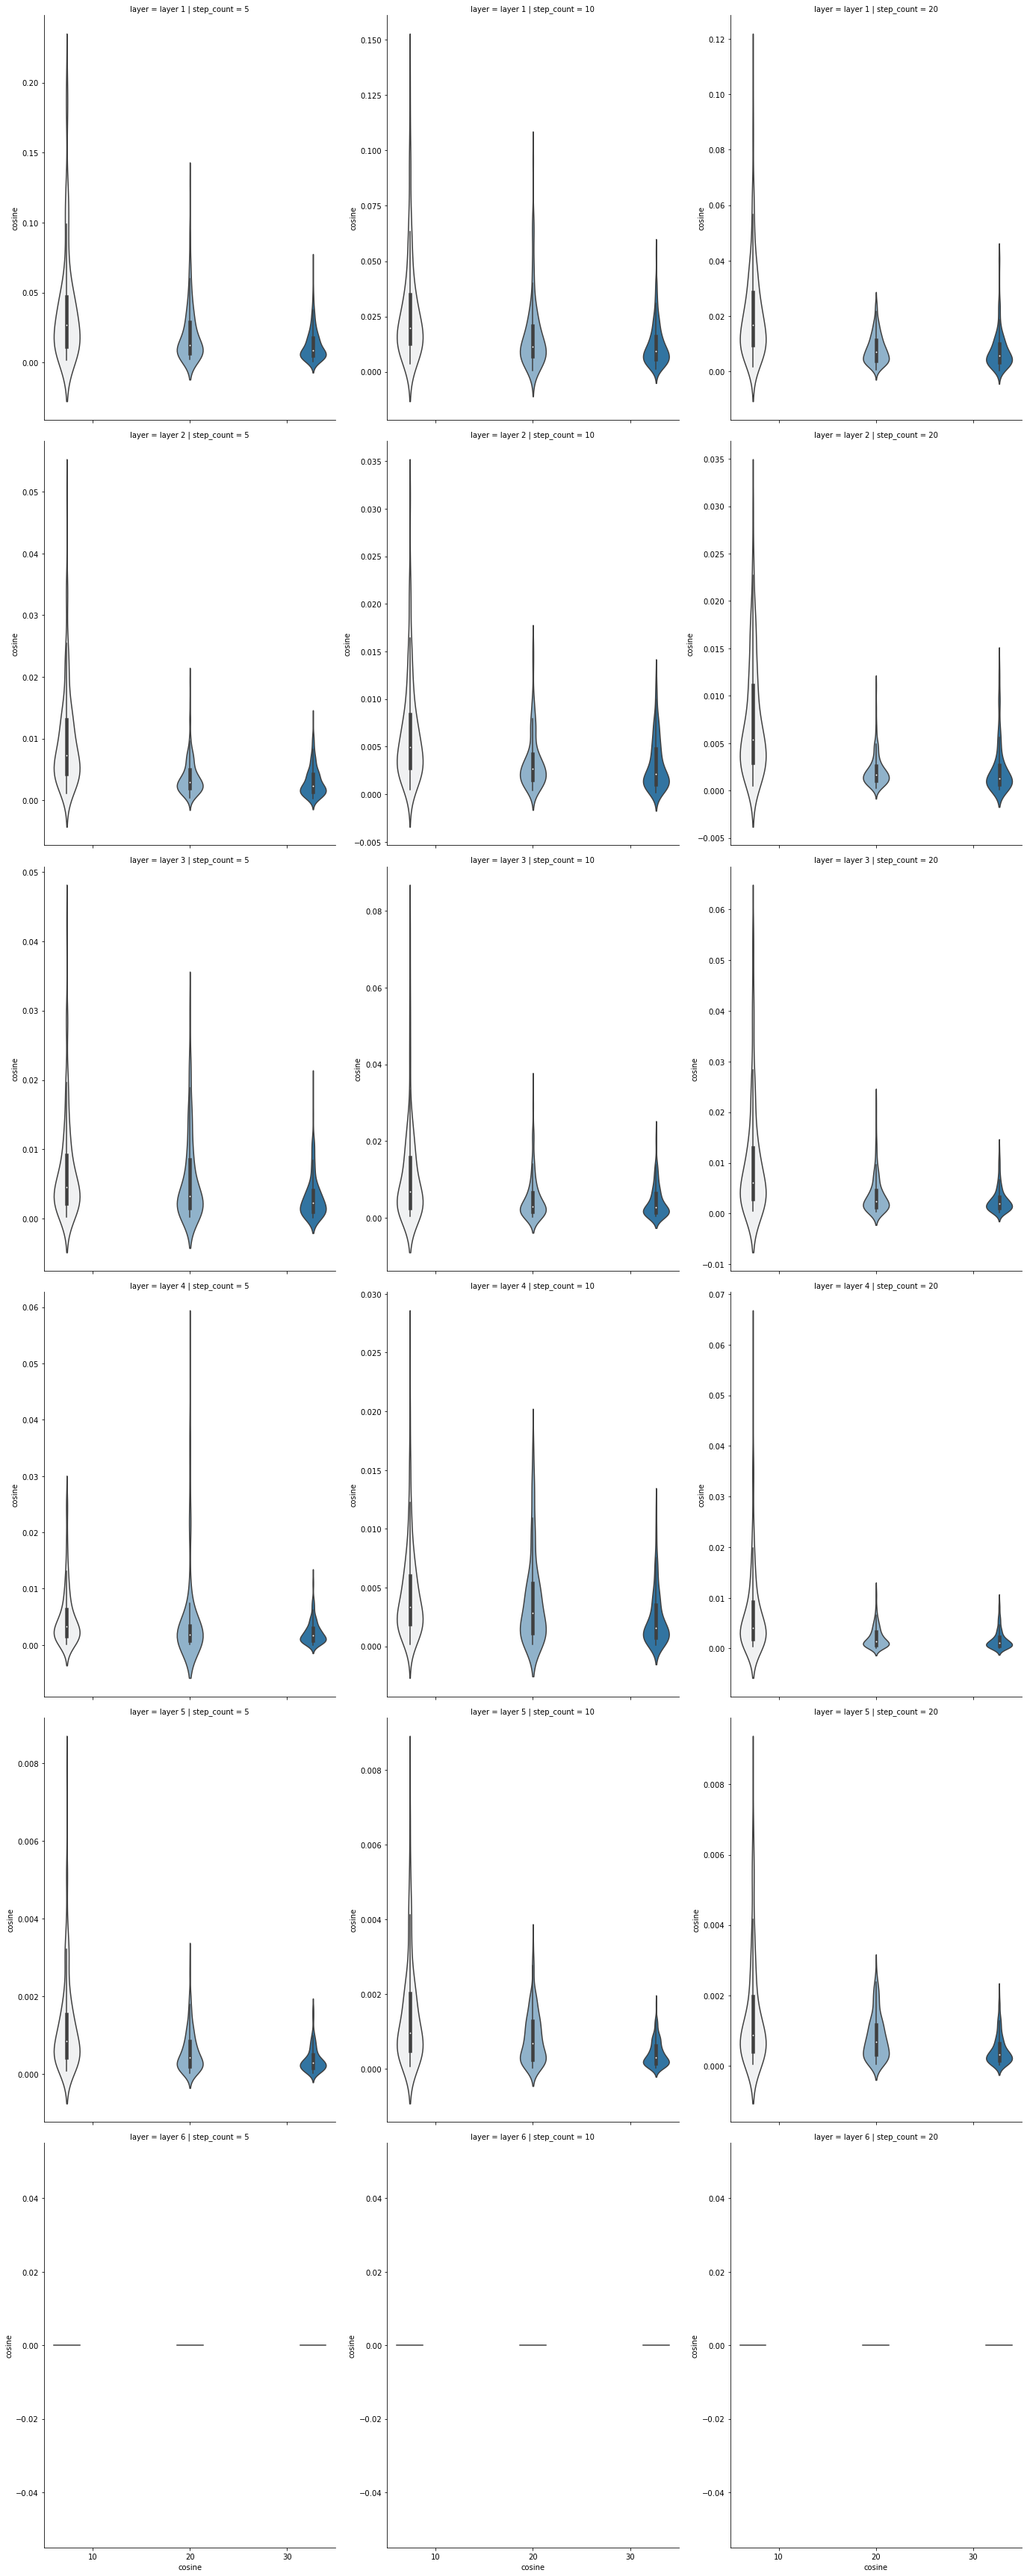

In [306]:
def make_facet(y, **kwargs):
    v = sns.violinplot(y=y,x="sample_size", hue="sample_size", **kwargs)
g = sns.FacetGrid(ungrammatical, col="step_count",  row="layer", height=8, aspect=.8, sharey=False)
g.map_dataframe(make_facet, "cosine")
plt.show()

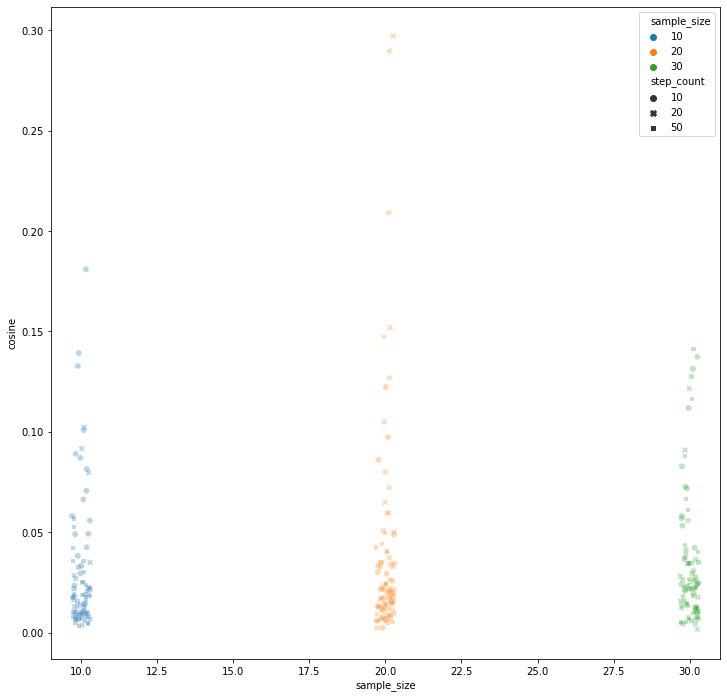

In [245]:
fig, ax = plt.subplots(figsize=(12, 12))
#sns.swarmplot(data=cosine_df, x="sample_size", y="cosine", hue="step_count", ax=ax)
sns.scatterplot(data=cosine_df[cosine_df['layer'] == "layer 1"], x="sample_size", y="cosine", style="step_count", hue="sample_size", alpha=0.3, ax=ax)

dots = ax.collections[0]
offsets = np.array(dots.get_offsets())
#print(offsets[10:,:], offsets.shape)
jitter = np.random.uniform(-0.3,0.3, offsets.shape[0])
jittered_offsets = offsets
jittered_offsets[:,0] += jitter
#print(jittered_offsets[10:,:])
dots.set_offsets(jittered_offsets)

#plt.tight_layout()
plt.show()

In [124]:
(full_df
     .groupby(['variable', 'sample', 'sent', 'layer'])
     .agg({'value': np.max})
     .groupby(['variable', 'sample', 'sent'])
     .agg({'value': [np.median, np.max, np.sum, np.std]})
)

value       \
                                                                median amax   
variable sample sent                                                          
mouse    0      The cat from the neighbours chase a [MASK].   0.690320  1.0   
                The cat from the neighbours chases a [MASK].  0.759798  1.0   
         1      The cat from the neighbours chase a [MASK].   0.717578  1.0   
                The cat from the neighbours chases a [MASK].  0.709123  1.0   
         2      The cat from the neighbours chase a [MASK].   0.766961  1.0   
                The cat from the neighbours chases a [MASK].  0.754632  1.0   
         3      The cat from the neighbours chase a [MASK].   0.696907  1.0   
                The cat from the neighbours chases a [MASK].  0.760262  1.0   

                                                                        \
                                                                   sum   
variable sample sent                                                     
mouse    0      The cat from the neighbours chase a [MASK].   4.105483   
                The cat from the neighbours chases a [MASK].  4.544575   
         1      The cat from the neighbours chase a [MASK].   4.195806   
                The cat from the neighbours chases a [MASK].  4.310436   
         2      The cat from the neighbours chase a [MASK].   4.477581   
                The cat from the neighbours chases a [MASK].  4.481132   
         3      The cat from the neighbours chase a [MASK].   4.170663   
                The cat from the neighbours chases a [MASK].  4.623288   

                                                                        
                                                                   std  
variable sample sent                                                    
mouse    0      The cat from the neighbours chase a [MASK].   0.229122  
                The cat from the neighbours chases a [MASK].  0.167430  
         1      The cat from the neighbours chase a [MASK].   0.229472  
                The cat from the neighbours chases a [MASK].  0.192345  
         2      The cat from the neighbours chase a [MASK].   0.187196  
                The cat from the neighbours chases a [MASK].  0.182285  
         3      The cat from the neighbours chase a [MASK].   0.209401  
                The cat from the neighbours chases a [MASK].  0.155155

In [129]:
len(full_df['sample_list'].unique())

8

In [136]:
html = html_for_sentences(full_df, mask_index, ["sent", "layer", "sample"])
display(HTML(html))

In [137]:
html = html_for_sentences(full_df, mask_index, ["sample", "layer", "sent"])
display(HTML(html))